# 시계열 데이터

In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [4]:
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1

learning_rate = 0.01
iterations = 500

xy = np.loadtxt("data-02-stock_daily.csv",delimiter = ",")
xy = xy[::-1]  #reverse order

In [6]:
print(xy.shape)

(732, 5)


In [8]:
train_size = int(len(xy)*0.7)
train_set = xy[0:train_size]
test_set = xy[train_size-seq_length:]
print(train_set.shape, test_set.shape)

(512, 5) (227, 5)


In [9]:
#데이터의 단위가 다르므로 스케일링
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [10]:
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [22]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    count = 0
    for i in range(0, len(time_series) - seq_length):
        count +=1
        _x = time_series[i:i + seq_length, :] #(7,5)
        _y = time_series[i + seq_length, [-1]]  #(1,1) 5개의 dim중 마지막값이 price(close)이므로!

        # Next close price
        if count < 2:
            print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    #dataX : (505,7,5), dataY : (505,1)
    # 7일차의 입력과 8일차의 종가에 대한 데이터
    print('shape of dataX, dataY:',np.array(dataX).shape, np.array(dataY).shape)
    return np.array(dataX), np.array(dataY)


In [23]:
# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
shape of dataX, dataY: (505, 7, 5) (505, 1)
[[0.47419206 0.50445037 0.51770809 0.22296353 0.49142842]
 [0.46909658 0.46301195 0.47045433 0.2111109  0.45809697]
 [0.40525134 0.46000606 0.44658508 0.18462886 0.4877246 ]
 [0.47395239 0.47450627 0.47948097 0.10216366 0.46012771]
 [0.40165458 0.41556139 0.43671021 0.10180958 0.41538731]
 [0.3882862  0.43583844 0.43786128 0.08716152 0.4625172 ]
 [0.44583656 0.44031831 0.44222

In [61]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        #(505,7,5)
        x, _status = self.rnn(x)
        #(505,7,10)
        x = self.fc(x[:, -1])
        #x[:,-1] : (505,10) 7개의 dim중에서 마지막 값만 남기고 압축
        
        #(505,1)
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)
        

In [62]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [63]:
for i in range(iterations):
    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i,loss.item())

0 0.47091034054756165
1 0.37702450156211853
2 0.296494722366333
3 0.22742369771003723
4 0.1678139716386795
5 0.11706338077783585
6 0.07623916864395142
7 0.04770470783114433
8 0.03422323614358902
9 0.03686407208442688
10 0.05093398317694664
11 0.06511900573968887
12 0.07087456434965134
13 0.06727384775876999
14 0.057602208107709885
15 0.04588233307003975
16 0.03521737456321716
17 0.027327360585331917
18 0.02268875204026699
19 0.020912708714604378
20 0.02114730142056942
21 0.022402456030249596
22 0.023777980357408524
23 0.024602653458714485
24 0.02449086308479309
25 0.023333802819252014
26 0.02125052735209465
27 0.01852070353925228
28 0.015512029640376568
29 0.01260856632143259
30 0.010143250226974487
31 0.008339614607393742
32 0.007271087262779474
33 0.006849219091236591
34 0.006850172765552998
35 0.006979451980441809
36 0.006959497928619385
37 0.006611495744436979
38 0.005901549942791462
39 0.004935476928949356
40 0.00390798831358552
41 0.003028836101293564
42 0.0024533194955438375
43 

335 0.0016246455488726497
336 0.001623546122573316
337 0.0016224498394876719
338 0.0016213558847084641
339 0.0016202643746510148
340 0.0016191754257306457
341 0.001618089503608644
342 0.0016170060262084007
343 0.0016159249935299158
344 0.0016148462891578674
345 0.0016137704951688647
346 0.0016126974951475859
347 0.001611626474186778
348 0.0016105585964396596
349 0.0016094932798296213
350 0.001608429942280054
351 0.001607369165867567
352 0.0016063111834228039
353 0.0016052554128691554
354 0.0016042027855291963
355 0.00160315225366503
356 0.0016021043993532658
357 0.001601058873347938
358 0.001600016257725656
359 0.001598975621163845
360 0.0015979375457391143
361 0.0015969015657901764
362 0.0015958688454702497
363 0.0015948384534567595
364 0.0015938099240884185
365 0.0015927843051031232
366 0.0015917608980089426
367 0.0015907399356365204
368 0.001589721767231822
369 0.0015887056943029165
370 0.0015876918332651258
371 0.0015866805333644152
372 0.001585671678185463
373 0.001584665267728269

In [64]:
t = np.random.randn(3,2,1)
print(t)
t1 = t[:,-1]
print(t1)

[[[-1.06467238]
  [ 0.78395303]]

 [[-0.95167041]
  [ 0.04490077]]

 [[-0.23074319]
  [ 1.24865837]]]
[[0.78395303]
 [0.04490077]
 [1.24865837]]


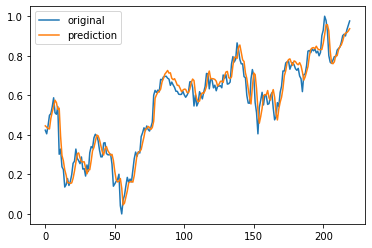

In [65]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original','prediction'])
plt.show()